# import uci dataset



In [ ]:
import pandas as pd

# Load directly from UCI repository URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"

columns = [
    "age", "workclass", "fnlwgt", "education", "education-num",
    "marital-status", "occupation", "relationship", "race",
    "sex", "capital-gain", "capital-loss", "hours-per-week",
    "native-country", "income"
]

train_data = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
train_data['income'] = train_data['income'].str.rstrip('.')
train_data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
attributes_to_ignore = ['capital-gain','capital-loss']     # attributes with unique values such as names and ids that dont hold any information for the data and make learning harder
discrete_columns = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country','income']
train_data = train_data.drop(attributes_to_ignore, axis = 1)
train_data = train_data.dropna()
train_data = train_data.reset_index(drop=True)

In [ ]:
def rename_categorical_values(df):
    df = df.copy()  # Avoid modifying original DataFrame
    for col in df.select_dtypes(include=['object', 'category']).columns:
        unique_vals = df[col].unique()
        for val in unique_vals:
            if isinstance(val, str):
                # Find if this value exists in multiple columns
                count = sum((df[c] == val).any() for c in df.select_dtypes(include=['object', 'category']).columns)
                if count > 1:
                    df[col] = df[col].replace(val, f"{val}_{col}")
    return df

train_data = rename_categorical_values(train_data)

In [ ]:
num_features = 10
num_negatives = 5
discrete_columns = [c for c in train_data.columns if c in discrete_columns]    # puts disrete_columns in the right order

discrete_df = train_data[discrete_columns]

# Import csv dataset

In [ ]:
from google.colab import files

files.upload()    # Upload the training data csv. The following implementation drops the null values. Custom handling before uploading is encouraged

In [ ]:
dataset_name = '...'      # use the name .csv file imported above
discrete_columns = []
attributes_to_ignore = []     # attributes with unique values such as names and ids that dont hold any information for the data and make learning harder

num_features = 15
num_negatives = 5

In [ ]:
import pandas as pd

train_data = pd.read_csv(dataset_name)
train_data = train_data.dropna().reset_index(drop=True)
train_data = train_data.drop(attributes_to_ignore, axis = 1)
discrete_columns = [c for c in train_data.columns if c in discrete_columns]    # puts disrete_columns in the right order

discrete_df = train_data[discrete_columns]

# Embeddings


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import random
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset


class EmbeddingsNN(nn.Module):
    def __init__(self, discrete_df, num_features, num_negatives, pairs_pc, batch_size = 4000):
        """
        Initialize the embedding model.

        Args:
            discrete_df (pd.DataFrame): DataFrame with only discrete categorical columns.
            num_features (int): Embedding dimension size.
            num_negatives (int): Number of negative samples per positive sample.
            pairs_pc (float): Percentage of column pairs to sample for training.
            batch_size (int, optional): Batch size for training. Defaults to 4000.
        """
        super(EmbeddingsNN, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.criterion = nn.BCELoss()
        self.num_epochs = 150
        self.num_negatives = num_negatives
        self.pairs_pc = pairs_pc
        self.batch_size = batch_size
        self.negtive_samples = []
        self.discrete_columns = discrete_df.columns
        self.num_words = self.compute_num_words(discrete_df)
        self.num_features = num_features
        self.f_matrix = self.get_f_matrix(self.word_occurance_pairs)
        self.column_pairs= [
        (col1, col2)
        for col1 in self.discrete_columns
        for col2 in self.discrete_columns
        if col1 != col2
        ]

        # E is the matrix we want to learn
        self.one_hot_matrix = torch.eye(self.num_words, device=self.device)
        self.E = nn.Parameter(torch.empty(self.num_words, self.num_features, device=self.device))  # Matrix E (learnable)
        self.theta = nn.Parameter(torch.empty(self.num_features, self.num_words, device=self.device))  # Vector θ (learnable)

        nn.init.xavier_uniform_(self.E)
        nn.init.xavier_uniform_(self.theta)

        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)

        self.to(self.device)


    def forward(self, idx_c, idx_t, batched=False):
        """
        Forward pass computes probability of co-occurrence between center and target words.

        Args:
            idx_c (Tensor or int): Indices of center words (batch or single).
            idx_t (Tensor or int): Indices of target words (batch or single).
            batched (bool): If True, treat inputs as batches.

        Returns:
            Tensor: Sigmoid probability of co-occurrence.
        """
        e_c = self.E[idx_c]
        theta_t = self.theta[:, idx_t]
        if batched:
            return torch.sigmoid(torch.sum((e_c *(theta_t.T)), dim=1))
        else:
            return torch.sigmoid(torch.dot(e_c, theta_t))

    def compute_num_words(self, discrete_df):
        """
        Compute the total number of unique discrete values ("words") and
        build word-to-index mapping.

        Args:
            discrete_df (pd.DataFrame): Input categorical data.

        Returns:
            int: Total number of unique words.
        """

        self.word_occurance_pairs = []
        self.values_per_column = [0]*len(self.discrete_columns)
        for column in self.discrete_columns:
            value_counts_pairs = discrete_df[column].value_counts().items()
            for v,c in value_counts_pairs:
              self.word_occurance_pairs.append([v,c])
              self.values_per_column[self.discrete_columns.get_loc(column)] += 1

        self.words = [word for word, count in self.word_occurance_pairs]
        self.word_to_idx = {word: idx for idx, word in enumerate(self.words)}
        return len(self.words)

    def get_f_matrix(self, word_occurance_pairs):
        """
        Compute negative sampling probabilities for each word.

        Args:
            word_occurance_pairs (list): List of [word, count] pairs.

        Returns:
            list: List of [index, probability] for negative sampling.
        """
        total = sum(x[1] for x in word_occurance_pairs)
        for i in range(len(word_occurance_pairs)):
          word_occurance_pairs[i][1] = word_occurance_pairs[i][1]/total
        sum_of_fs = sum(x[1]**(3/4) for x in word_occurance_pairs)
        f_matrix =[]
        for i in range(len(word_occurance_pairs)):
            f_matrix.append([i, word_occurance_pairs[i][1]**(3/4)/sum_of_fs])
        return f_matrix


    def get_training_pairs(self, pairs_pc, total_batch):
        """
        Sample positive training pairs (center-target) from random column pairs.

        Args:
            pairs_pc (float): Percentage of column pairs to sample.
            total_batch (pd.DataFrame): Current batch of data.

        Returns:
            Tensor: Training pairs of word indices with shape (num_pairs, 2).
        """
        num_pairs = int(len(self.column_pairs)*pairs_pc)
        pairs_set = random.sample(self.column_pairs, k=num_pairs)
        training_pairs = []
        for c, t in pairs_set:
          centers = total_batch[c].map(self.word_to_idx)
          targets = total_batch[t].map(self.word_to_idx)
          pairs = torch.stack([
              torch.tensor(centers.values, device=self.device),
              torch.tensor(targets.values, device=self.device)
          ], dim=1)
          training_pairs.append(pairs)

        # Concatenate all pairs from all column combinations
        training_pairs = torch.cat(training_pairs, dim=0)
        return training_pairs


    def get_negative_samples(self, positive_idxs, num_negatives):
        """
        Generate negative samples for each positive target index.

        Args:
            positive_idxs (Tensor): Indices of positive target words.
            num_negatives (int): Number of negatives to sample per positive.

        Returns:
            Tensor: Negative samples with shape (batch_size, num_negatives).
        """

        neg_samples = []
        numbers, probabilities = zip(*self.f_matrix)
        for _ in range(num_negatives):
            r = random.choices(numbers, weights=probabilities, k=len(positive_idxs))
            neg_samples.append(r)
        return torch.tensor(neg_samples, device = self.device).T


    def train(self):
        num_samples = len(discrete_df)
        counter = 0

        for epoch in range(self.num_epochs):
            total_loss = 0

            for i in range(0, num_samples, self.batch_size):
                counter+=1
                batch_df = discrete_df.iloc[i:i+self.batch_size]
                if len(batch_df) == 0:
                    continue

                training_pairs = self.get_training_pairs(self.pairs_pc, batch_df)
                targets = training_pairs[:, 1]
                negative_samples = self.get_negative_samples(targets, self.num_negatives)

                tp_exp = training_pairs[:, 0].repeat_interleave(negative_samples.shape[1])
                negative_samples = negative_samples.flatten()
                negative_samples = torch.stack([tp_exp, negative_samples], dim=1)

                self.optimizer.zero_grad()

                pos_scores = self.forward(training_pairs[:,0], training_pairs[:,1], batched=True)
                pos_loss = self.criterion(pos_scores, torch.ones_like(pos_scores))

                neg_scores = self.forward(negative_samples[:,0], negative_samples[:,1], batched=True)
                neg_loss = self.criterion(neg_scores, torch.zeros_like(neg_scores))

                loss = (pos_loss + neg_loss)
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()

            if epoch%10 == 0:
                print(f"Epoch {epoch}, Loss: {total_loss:.4f}")



In [ ]:
pair_prob = 0.3  # the probability of selecting a positive sample for training in a given epoch
ebd = EmbeddingsNN(discrete_df, num_features, num_negatives, pair_prob)
ebd.train()

In [ ]:
E = torch.tanh(ebd.E.T).detach().cpu().numpy()
embeddings_df = pd.DataFrame(E, columns = ebd.words)

In [ ]:
embeddings_df = (embeddings_df - embeddings_df.mean()) / embeddings_df.std()

In [ ]:
#normalize the values of the embeddings
max = embeddings_df.abs().max().max()
embeddings_df = (embeddings_df / max).astype('float32')

#apply embeddings on words
def word_to_vec(word):
    if word in embeddings_df.columns.tolist():
       return embeddings_df[word].values

#construct the new dataframe with continuous ad embedded columns
def construct_dataset(train_df):
    i=0
    _df = train_df.copy()
    cat_col_pos = []
    for column in _df:
       if column in discrete_columns:
          cat_col_pos.append(column)
          _df[column] = _df[column].apply(lambda x: word_to_vec(x))
       else:
          cat_col_pos.append(None)
    return _df, cat_col_pos

new_df, cat_cols_pos = construct_dataset(train_data)

In [ ]:
new_rows = []
for _, row in new_df.iterrows():
    flat = []
    for val in row:
        if isinstance(val, (list, np.ndarray)):
            flat.extend(val)  # unpack lists or arrays
        else:
            flat.append(val)  # keep scalar values
    new_rows.append(flat)

new_rows = np.asarray(new_rows)

# Step eval

In [ ]:
from scipy.stats import wasserstein_distance

def avg_num_w_dist(real_data, model_data):
    dists = 0
    for c in range(real_data.shape[1]):
        dists += wasserstein_distance(real_data[:,c], model_data[:,c])
    avg_dists = dists/real_data.shape[1]
    return avg_dists

In [ ]:
import numpy as np

def L2_correlation_matrices(real_data, model_data):
        # Compute correlation matrices
        corr1 = np.corrcoef(real_data, rowvar=False)
        corr2 = np.corrcoef(model_data, rowvar=False)

        # Compute the L2 (Euclidean) distance between the flattened matrices
        l2_distance = np.linalg.norm(corr1 - corr2)

        return l2_distance



#DDPM

Baesd on Algorithm 1 (Trainings) and Algorithm 2 (Sampling) of https://arxiv.org/pdf/2006.11239 at page 4

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math



class DenoiseMLP(nn.Module):
    def __init__(self, data_dim, time_dim):
        super().__init__()
        self.time_embed = nn.Sequential(
            nn.Linear(1, time_dim), nn.ReLU(),
            nn.Linear(time_dim, time_dim)
        )
        self.net = nn.Sequential(
            nn.Linear(data_dim + time_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.LayerNorm(1024),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Linear(512, data_dim),
        )

    def forward(self, x, t):
        """
        Forward pass of the denoising network.

        Args:
            x (Tensor): Noisy input data x_t
            t (Tensor): Timestep tensor of shape (batch_size,)

        Returns:
            Tensor: Predicted noise ε_θ(x_t, t)
        """
        t = t.view(-1, 1).float() / 1000  # Normalize timestep
        time_emb = self.time_embed(t)
        x = torch.cat([x, time_emb], dim=1)
        return self.net(x)


class eDDPM(nn.Module):
    def __init__(self, data_dim, time_dim=128, T=1000, lr=5e-5, cuda=True):
        super().__init__()
        self.T = T
        self.lr = lr
        self.data_dim = data_dim

        if not cuda or not torch.cuda.is_available():
            self.device = 'cpu'
        elif isinstance(cuda, str):
            self.device = cuda
        else:
            self.device = 'cuda'

        self.betas = torch.linspace(1e-5, 0.01, T).to(self.device)
        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod).to(self.device)
        self.sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - self.alphas_cumprod)

        self.device = torch.device(self.device)
        self.denoiser = DenoiseMLP(data_dim, time_dim).to(self.device)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

    def q_sample(self, x0, t, noise=None):
        """
        Forward process: sample x_t from q(x_t | x_0)

        Args:
            x0 (Tensor): Original data
            t (Tensor): Timesteps
            noise (Tensor or None): Optional noise; if None, sampled from N(0, I)

        Returns:
            Tensor: Noised version x_t
        """
        if noise is None:
            noise = torch.randn_like(x0)
        return self.sqrt_alphas_cumprod[t].unsqueeze(1) * x0 + self.sqrt_one_minus_alphas_cumprod[t].unsqueeze(1) * noise

    def train(self, data, num_epochs=500, batch_size=1000):
        or_data = data.copy()
        data = torch.from_numpy(data).float().to(self.device)

        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        data_loader = torch.utils.data.DataLoader(data, batch_size)

        self.avg_w_distances = []
        self.corr_l2_distances = []

        for epoch in range(num_epochs):
            for batch in data_loader:
                weights = torch.linspace(0.1, 1.0, self.T)  # increasing weight
                t = torch.multinomial(weights, batch.shape[0], replacement=True).to(self.device)
                noise = torch.randn_like(batch)
                xt = self.q_sample(batch, t, noise)

                pred_noise = self.denoiser(xt, t)
                loss = F.mse_loss(pred_noise, noise)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if epoch % 20 == 0:
                curr_samples = self.sample(1000)
                curr_samples = curr_samples.detach().cpu().numpy()
                avg_w_dist = avg_num_w_dist(or_data, curr_samples)
                self.avg_w_distances.append(avg_w_dist)
                l2_dist = L2_correlation_matrices(or_data, curr_samples)
                self.corr_l2_distances.append(l2_dist)
                print(f"Epoch {epoch}: loss {loss.item():.4f}")

        return self.avg_w_distances, self.corr_l2_distances

    #@torch.no_grad()
    def sample(self, num_samples):
        """
        Generates synthetic samples by reverse diffusion process p_θ(x_{t-1} | x_t).

        Args:
            num_samples (int): Number of samples to generate

        Returns:
            Tensor: Generated synthetic samples
        """
        with torch.no_grad():
            x_t = torch.randn((num_samples, self.data_dim), device = self.device)
            for t in reversed(range(self.T)):
                t_tensor = torch.tensor([t]*num_samples, device=self.device)
                pred_noise = self.denoiser(x_t, t_tensor)
                beta_t = self.betas[t]
                alpha_t = self.alphas[t]
                alpha_bar_t = self.alphas_cumprod[t]
                sigmas = torch.sqrt(beta_t)

                x_t_minus_one = (1 / torch.sqrt(alpha_t)) * (x_t - (1-alpha_t) / torch.sqrt(1 - alpha_bar_t) * pred_noise)
                x_t = x_t_minus_one
                if t > 0:
                    noise = torch.randn_like(x_t)
                    x_t += sigmas * noise
            return x_t

In [ ]:
from sklearn.preprocessing import StandardScaler

l_nr = np.log1p(new_rows+0.01)  #For smoothing. It compresses large values and expands small ones

scaler = StandardScaler()
X_scaled = scaler.fit_transform(l_nr)

eddpm = eDDPM(l_nr.shape[1])
res = eddpm.train(X_scaled)

Epoch 0: loss 0.7873
Epoch 20: loss 0.1229
Epoch 40: loss 0.1044
Epoch 60: loss 0.0837
Epoch 80: loss 0.0770
Epoch 100: loss 0.0659
Epoch 120: loss 0.0644
Epoch 140: loss 0.0703
Epoch 160: loss 0.0655
Epoch 180: loss 0.0660
Epoch 200: loss 0.0596
Epoch 220: loss 0.0591
Epoch 240: loss 0.0543
Epoch 260: loss 0.0557
Epoch 280: loss 0.0607
Epoch 300: loss 0.0538
Epoch 320: loss 0.0513
Epoch 340: loss 0.0476
Epoch 360: loss 0.0539
Epoch 380: loss 0.0552
Epoch 400: loss 0.0500
Epoch 420: loss 0.0532
Epoch 440: loss 0.0520
Epoch 460: loss 0.0501
Epoch 480: loss 0.0475


#Plotting progress graphs

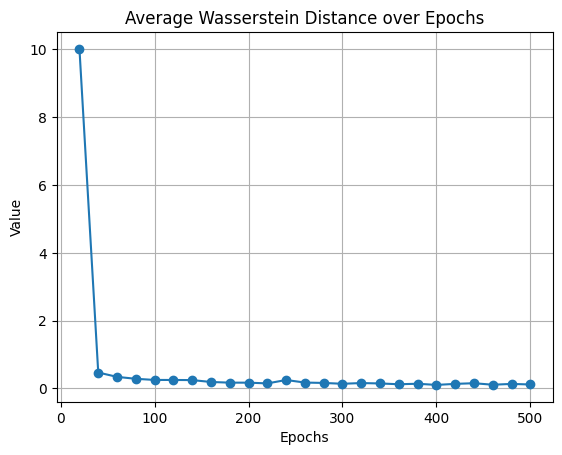

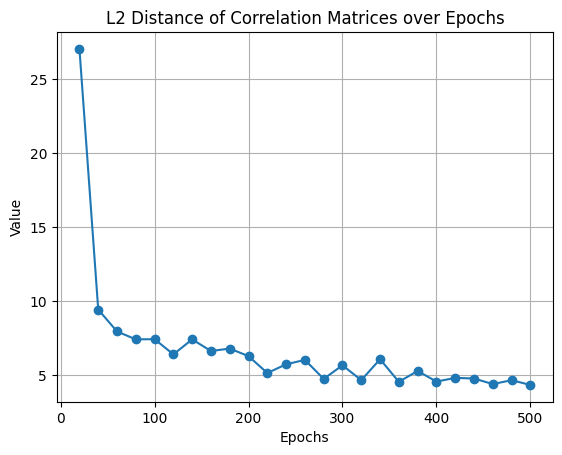

In [ ]:
import matplotlib.pyplot as plt

values = res[0]

# Epochs corresponding to each value
epochs = [20 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("Average Wasserstein Distance over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

values = res[1]

# Epochs corresponding to each value
epochs = [20 * (i + 1) for i in range(len(values))]

# Plot
plt.plot(epochs, values, marker='o')
plt.title("L2 Distance of Correlation Matrices over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.grid(True)
plt.show()

#Sampling

In [ ]:
d = eddpm.sample(5000)
d = d.detach().cpu().numpy()

samples = scaler.inverse_transform(d)
samples = np.expm1(samples)

In [ ]:
def get_discrete_values(tmp, start, end):
    X = embeddings_df.iloc[:, start : end]
    res=[]
    score = float('inf')
    for x in tmp:
        att=None
        score = float('inf')
        for v in X:
            s = nn.CosineEmbeddingLoss()(torch.tensor(X[v].values).unsqueeze(0), torch.tensor(x).unsqueeze(0), torch.ones(x.shape))
            if (s<score):
               score=s
               att=v
        res.append(att)
    return res


def create_final_df(sample, columns, discrete_columns, num_features):
    final_df = pd.DataFrame()
    i=0
    j=0
    col_atts_indeces = np.concatenate([np.zeros(1).astype(int), np.cumsum(ebd.values_per_column)])
    for c in columns:
        if c in discrete_columns:
            tmp = sample[:,i:i+num_features]
            attributes = get_discrete_values(tmp, col_atts_indeces[j], col_atts_indeces[j+1])
            j+=1
            final_df[c] = attributes
            i+=num_features
        else:
            final_df[c] = sample[:,i]
            i+=1
    return final_df

In [ ]:
final_df = create_final_df(samples, new_df.columns, discrete_columns, num_features)

In [ ]:
final_df['age'] = final_df['age'].astype(int)
final_df['hours-per-week'] = final_df['hours-per-week'].astype(int)
final_df['education-num'] = final_df['education-num'].astype(int)
final_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,income
0,36,Private,207773.828125,Some-college,10,Divorced,Adm-clerical,Unmarried,White,Female,33,United-States,<=50K
1,52,Private,95390.882812,Masters,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,45,United-States,<=50K
2,39,Self-emp-not-inc,139913.437500,HS-grad,9,Divorced,Machine-op-inspct,Unmarried,White,Male,48,United-States,<=50K
3,25,Self-emp-inc,109980.085938,11th,6,Married-civ-spouse,Exec-managerial,Husband,White,Male,62,United-States,>50K
4,68,Private,416473.656250,Some-college,9,Divorced,Sales,Unmarried,Black,Female,30,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,19,Private,252848.046875,HS-grad,9,Never-married,Exec-managerial,Not-in-family,White,Female,36,United-States,<=50K
4996,36,Local-gov,103054.617188,Bachelors,12,Never-married,Adm-clerical,Not-in-family,White,Male,30,United-States,<=50K
4997,38,Private,96129.242188,12th,7,Divorced,Craft-repair,Not-in-family,White,Male,20,?,<=50K
4998,54,?_workclass,37395.882812,HS-grad,8,Married-civ-spouse,?_occupation,Husband,White,Male,23,United-States,<=50K


from matplotlib import pyplot as plt
final_df['age'].plot(kind='hist', bins=20, title='age')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_df['fnlwgt'].plot(kind='hist', bins=20, title='fnlwgt')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_df['education-num'].plot(kind='hist', bins=20, title='education-num')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_df['hours-per-week'].plot(kind='hist', bins=20, title='hours-per-week')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
final_df.groupby('workclass').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
final_df.groupby('marital-status').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
final_df.groupby('relationship').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
final_df.groupby('race').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_df.plot(kind='scatter', x='age', y='fnlwgt', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_df.plot(kind='scatter', x='fnlwgt', y='education-num', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_df.plot(kind='scatter', x='education-num', y='hours-per-week', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
final_df['age'].plot(kind='line', figsize=(8, 4), title='age')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final_df['fnlwgt'].plot(kind='line', figsize=(8, 4), title='fnlwgt')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final_df['education-num'].plot(kind='line', figsize=(8, 4), title='education-num')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
final_df['hours-per-week'].plot(kind='line', figsize=(8, 4), title='hours-per-week')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['marital-status'].value_counts()
    for x_label, grp in final_df.groupby('workclass')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('workclass')
_ = plt.ylabel('marital-status')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['relationship'].value_counts()
    for x_label, grp in final_df.groupby('marital-status')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('marital-status')
_ = plt.ylabel('relationship')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['race'].value_counts()
    for x_label, grp in final_df.groupby('relationship')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('relationship')
_ = plt.ylabel('race')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['sex'].value_counts()
    for x_label, grp in final_df.groupby('race')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('race')
_ = plt.ylabel('sex')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_df['workclass'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_df, x='age', y='workclass', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_df['marital-status'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_df, x='age', y='marital-status', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_df['relationship'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_df, x='age', y='relationship', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(final_df['race'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(final_df, x='age', y='race', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
from google.colab import files

final_df.to_csv('final_df.csv', index=False)
files.download('final_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>